In [536]:
import numpy as np
import concurrent.futures
from tqdm.notebook import tqdm
import os
import matplotlib as mpt
import matplotlib.pyplot as plt
import matplotlib.patches as patche
from matplotlib import style
import pylab
#speed things up
import numba
from numba import njit
from numba import jit
from numba import prange
from numba.experimental import jitclass
from scipy.optimize import curve_fit
#from numba_progress import ProgressBar
#from scipy.ndimage import convolve, generate_binary_structure
from timeit import default_timer as timer
from time import sleep
#style designed by me for plottin (version 2)
plt.style.use(['science','notebook','grid'])
plt.rcParams['mathtext.fontset'] = 'stix'

fig = (9,6)
params = {'figure.figsize': fig,
        'legend.fontsize': 2.3*fig[1],
         'axes.labelsize': 2.3*fig[1],
         'axes.titlesize': 2.6*fig[1],
         'xtick.labelsize': 2*fig[1],
         'ytick.labelsize': 2*fig[1],
         'font.family' : 
          'serif'
          }
pylab.rcParams.update(params)

In [2]:
def getColor(c, N, idx):
    cmap=mpt.colormaps.get_cmap(c)
    norm = mpt.colors.Normalize(vmin=0.0, vmax=N - 1)
    return cmap(norm(idx))

In [3]:
@njit(parallel=True)
def correlation(data, stop):
#compute the auto-correlation time of an observable for a given simulation 
    # corr = np.array(
    #     [(data**2).mean() - (data.mean())**2] + [(data[:-k] * data[k:]).mean() - (data.mean())**2 for k in range(1,stop)]
    # )
    # if corr[0]!=0: corr_norm = corr/corr[0]
    # corr = np.zeros(stop)
    # for k in prange(stop):
    #     for i in range(1,len(data) - k):
    #         corr[k] += (1/(len(data)-k)) * (data[i]*data[k+i])
    #     corr[k] = corr[k] - (data.mean())**2
    
    corr = np.zeros(stop)
    d_mean = data.mean()
    for k in prange(stop):
        for i in range(1,len(data) - k):
            corr[k] += (1/(len(data)-k)) * (data[i] - d_mean) * (data[i+k] - d_mean)    
    return corr
    

In [4]:
def blocking(data, bin_size):
    nb = int(len(data)/bin_size) #num of blocks
    #lets build the blocks with list comprehension
    blocks = [data[i*bin_size : (i+1)*bin_size] for i in range(nb)]
    averages = np.array([b.mean() for b in blocks]) #average for each block
    return averages.std(ddof=1)/np.sqrt(nb) if nb > 1 else 0

In [5]:
def f_corr(x, a, tau):
    return a * np.exp(-x/tau)    

In [493]:
dir1 = 'sim_b10'
dir2 = 'sim_b10_metro'
dir3 = 'sim_b10_metro05'
names = os.getcwd() + '/' + dir1 + '/' + 'simulation'

In [7]:
#key to access all the data 
a=np.geomspace(0.001,1,200)
b=np.geomspace(0.001,0.00103,30)
N = np.unique((10/a).astype(int))
N1 = np.unique((10/b).astype(int))
N2 = np.concatenate((N,N1))
N = N2[:-1]

In [8]:
N

array([   10,    11,    12,    13,    14,    15,    16,    17,    18,
          19,    20,    21,    22,    23,    24,    25,    26,    27,
          28,    29,    30,    31,    32,    33,    34,    36,    37,
          38,    40,    41,    42,    44,    46,    47,    49,    51,
          52,    54,    56,    58,    60,    62,    65,    67,    69,
          72,    74,    77,    80,    83,    86,    89,    92,    95,
          98,   102,   105,   109,   113,   117,   121,   126,   130,
         135,   139,   144,   149,   155,   160,   166,   172,   178,
         184,   191,   197,   204,   212,   219,   227,   235,   243,
         252,   261,   270,   280,   289,   300,   310,   321,   333,
         344,   357,   369,   382,   396,   410,   424,   439,   455,
         471,   488,   505,   523,   541,   560,   580,   601,   622,
         644,   666,   690,   714,   740,   766,   793,   821,   850,
         880,   911,   943,   977,  1011,  1047,  1084,  1122,  1162,
        1203,  1245,

In [275]:
names = os.getcwd() + '/' + dir1 + '/' + 'simulation'
etas = []
tau_s = []
ene_s = []
de = []
dt = []
for ns in tqdm(np.sort(N)):     
    charges, enes = np.loadtxt(f'{names}_{ns}.txt', unpack=True)
    stop = int(len(enes[30000:]/4))
    corr = correlation(charges[30000:], stop)
    corr_e = correlation(enes[30000:], stop)
    d_charges =np.full(len(corr),blocking(charges, 1000))
    d_ene = np.full(len(corr_e),blocking(enes, 1000))
    opt, cov = curve_fit(f_corr, np.arange(stop), corr, sigma=d_charges, p0=(1, 1))
    etas.append(10/ns)
    tau_s.append(opt[1])
    dt.append(cov[1,1]**(1/2))
    opt, cov = curve_fit(f_corr, np.arange(stop), corr_e, sigma=d_ene, p0=(1, 1))
    ene_s.append(opt[1])
    de.append(cov[1,1]**(1/2))

  0%|          | 0/217 [00:00<?, ?it/s]

/var/folders/7b/mxhdlhl16yjddckjcf2qpms00000gn/T/ipykernel_95678/3484102916.py:2: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-x/tau)
/opt/homebrew/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:488: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)
/opt/homebrew/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/7b/mxhdlhl16yjddckjcf2qpms00000gn/T/ipykernel_95678/3484102916.py:2: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-x/tau)


/var/folders/7b/mxhdlhl16yjddckjcf2qpms00000gn/T/ipykernel_95678/470074246.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)# Address proper subplot in 2x2 array


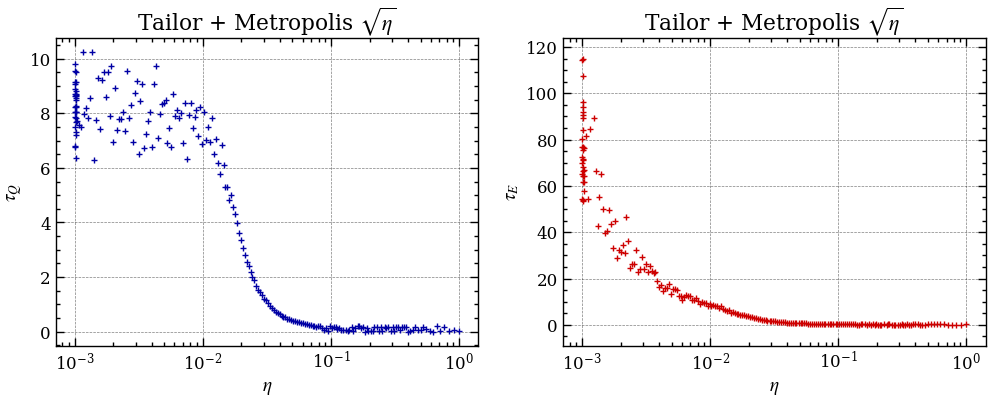

In [538]:
plt.figure(figsize=(12,4))
plt.title('') 

plt.subplot(1, 2, 1)# Address proper subplot in 2x2 array
plt.title(r'Tailor + Metropolis $\sqrt{\eta}$')
plt.plot(np.array(etas) , np.array(tau_s),'+',markersize='5', linewidth='.4',color=getColor('jet', 30,1), label='')
plt.xscale('log')
plt.ylabel(r'$\tau_Q$')
plt.xlabel(r'$\eta$')


plt.subplot(1, 2, 2)# Address proper subplot in 2x2 array
plt.title(r'Tailor + Metropolis $\sqrt{\eta}$')
plt.plot(np.array(etas) , np.array(ene_s),'+',markersize='5', linewidth='.4',color=getColor('jet', 30,27), label='')
plt.xscale('log')
plt.ylabel(r'$\tau_E$')
plt.xlabel(r'$\eta$')
plt.ylim(None, 124)
#plt.xlim(0.001,0.01)

plt.savefig('ciao', dpi=1000)

In [11]:
fltr = np.array([True,False,True,False,True,False,True]*31)
fltr

array([ True, False,  True, False,  True, False,  True,  True, False,
        True, False,  True, False,  True,  True, False,  True, False,
        True, False,  True,  True, False,  True, False,  True, False,
        True,  True, False,  True, False,  True, False,  True,  True,
       False,  True, False,  True, False,  True,  True, False,  True,
       False,  True, False,  True,  True, False,  True, False,  True,
       False,  True,  True, False,  True, False,  True, False,  True,
        True, False,  True, False,  True, False,  True,  True, False,
        True, False,  True, False,  True,  True, False,  True, False,
        True, False,  True,  True, False,  True, False,  True, False,
        True,  True, False,  True, False,  True, False,  True,  True,
       False,  True, False,  True, False,  True,  True, False,  True,
       False,  True, False,  True,  True, False,  True, False,  True,
       False,  True,  True, False,  True, False,  True, False,  True,
        True, False,

In [12]:
etas_m = []
taus_m = []
enes_m = []
de_m = []
dt_m = []
names = os.getcwd() + '/' + dir2 + '/' + 'simulation'
for ns in tqdm(np.sort(N)):     
    charges, enes = np.loadtxt(f'{names}_{ns}.txt', unpack=True)
    stop = int(len(enes[1000:]/4))
    corr = correlation(charges[1000:], stop)
    corr_e = correlation(enes[1000:], stop)
    d_charges =np.full(len(corr),blocking(charges, 1000))
    opt, cov = curve_fit(f_corr, np.arange(stop), corr, sigma=d_charges, p0=(1, 1))
    etas_m.append(10/ns)
    taus_m.append(opt[1])
    dt_m.append(np.sqrt(cov[1,1]))
    d_enes =np.full(len(corr_e),blocking(charges, 1000))
    opt, cov = curve_fit(f_corr, np.arange(stop), corr_e, sigma=d_enes, p0=(1, 1))
    enes_m.append(opt[1])
    de_m.append(np.sqrt(cov[1,1]))

  0%|          | 0/217 [00:00<?, ?it/s]

/var/folders/7b/mxhdlhl16yjddckjcf2qpms00000gn/T/ipykernel_95678/3484102916.py:2: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-x/tau)
/var/folders/7b/mxhdlhl16yjddckjcf2qpms00000gn/T/ipykernel_95678/3484102916.py:2: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-x/tau)
/opt/homebrew/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:803: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
/opt/homebrew/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:488: RuntimeWarning: invalid value encountered in multiply
  return transform * (func(xdata, *params) - ydata)


/var/folders/7b/mxhdlhl16yjddckjcf2qpms00000gn/T/ipykernel_95678/3669732165.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)# Address proper subplot in 2x2 array


Text(0.5, 0, '$\\eta$')

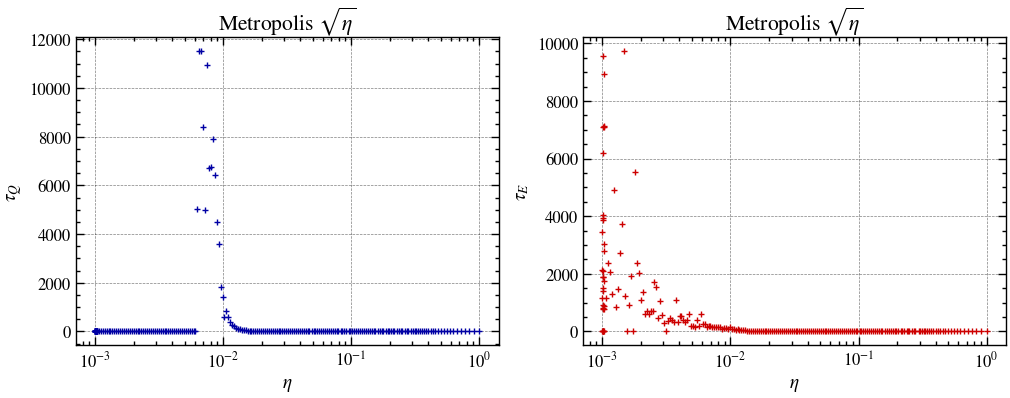

In [527]:
plt.figure(figsize=(12,4))
plt.title('') 

plt.subplot(1, 2, 1)# Address proper subplot in 2x2 array
plt.title(r'Metropolis $\sqrt{\eta}$')
plt.plot(np.array(etas) , np.array(taus_m),'+',markersize='5', linewidth='.4',color=getColor('jet', 30, 1), label='')
plt.xscale('log')
plt.ylabel(r'$\tau_Q$')
plt.xlabel(r'$\eta$')

plt.subplot(1, 2, 2)# Address proper subplot in 2x2 array
plt.title(r'Metropolis $\sqrt{\eta}$')
plt.plot(np.array(etas) , np.array(enes_m),'+',markersize='5', linewidth='.4',color=getColor('jet', 30, 27), label='')
plt.xscale('log')
plt.ylabel(r'$\tau_E$')
plt.xlabel(r'$\eta$')
#plt.ylim(None,1000)
#plt.xlim(0.001,0.01)

In [14]:
etas_m05 = []
taus_m05 = []
enes_m05 = []
dt_m05 = []
de_m05 = []
names = os.getcwd() + '/' + dir3 + '/' + 'simulation'
for ns in tqdm(np.sort(N)):     
    charges, enes = np.loadtxt(f'{names}_{ns}.txt', unpack=True)
    stop = int(len(enes[1000:]/4))
    corr = correlation(charges[1000:], stop)
    corr_e = correlation(enes[1000:], stop)
    d_charges =np.full(len(corr),blocking(charges, 1000))
    opt, cov = curve_fit(f_corr, np.arange(stop), corr, sigma=d_charges, p0=(1, 1))
    etas_m05.append(10/ns)
    taus_m05.append(opt[1])
    dt_m05.append(np.sqrt(cov[1,1]))
    d_enes =np.full(len(corr_e),blocking(charges, 1000))
    opt, cov = curve_fit(f_corr, np.arange(stop), corr_e, sigma=d_enes, p0=(1, 1))
    enes_m05.append(opt[1])
    de_m05.append(np.sqrt(cov[1,1]))

  0%|          | 0/217 [00:00<?, ?it/s]

/var/folders/7b/mxhdlhl16yjddckjcf2qpms00000gn/T/ipykernel_95678/3484102916.py:2: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-x/tau)
/var/folders/7b/mxhdlhl16yjddckjcf2qpms00000gn/T/ipykernel_95678/3484102916.py:2: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-x/tau)


/var/folders/7b/mxhdlhl16yjddckjcf2qpms00000gn/T/ipykernel_95678/4270030640.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)# Address proper subplot in 2x2 array


Text(0.5, 0, '$\\eta$')

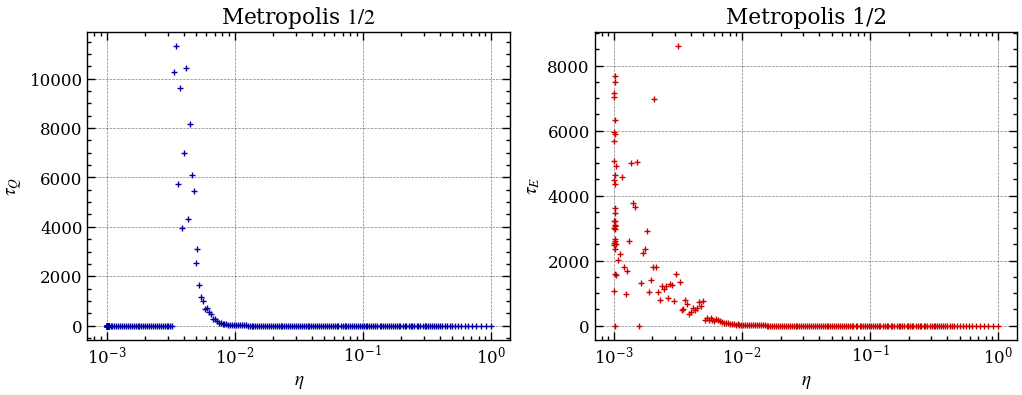

In [550]:
plt.figure(figsize=(12,4))
plt.title('') 

plt.subplot(1, 2, 1)# Address proper subplot in 2x2 array
plt.title(r'Metropolis $1/2$')
plt.plot(np.array(etas) , np.array(taus_m05),'+',markersize='5', linewidth='.4',color=getColor('jet', 30, 1), label='')
plt.xscale('log')
plt.ylabel(r'$\tau_Q$')
plt.xlabel(r'$\eta$')


plt.subplot(1, 2, 2)# Address proper subplot in 2x2 array
plt.title(r'Metropolis 1/2')
plt.plot(np.array(etas) , np.array(enes_m05),'+',markersize='5', linewidth='.4',color=getColor('jet', 30, 27), label='')
plt.xscale('log')
plt.ylabel(r'$\tau_E$')
plt.xlabel(r'$\eta$')

#plt.ylim(None,1000)
#plt.xlim(0.001,0.01)

In [16]:
###### TEST ########

"""corr = []
names = os.getcwd() + '/' + dir1 + '/' + 'simulation'
for ns in tqdm(np.sort(N)):
    charges, enes = np.loadtxt(f'{names}_{ns}.txt', unpack=True)
    stop = int(len(enes[1000:]))
    corr = correlation(charges[1000:], stop)
    d_charges =np.full(len(corr),blocking(charges, 1000))
    opt, cov = curve_fit(f_corr, np.arange(stop), corr, sigma=d_charges, p0=(1, 1))
    corr.append(opt[1])"""

  0%|          | 0/217 [00:00<?, ?it/s]

/var/folders/7b/mxhdlhl16yjddckjcf2qpms00000gn/T/ipykernel_95678/3484102916.py:2: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-x/tau)


AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [504]:
10/8703

0.001149029070435482

Text(0.5, 0, 'MC time')

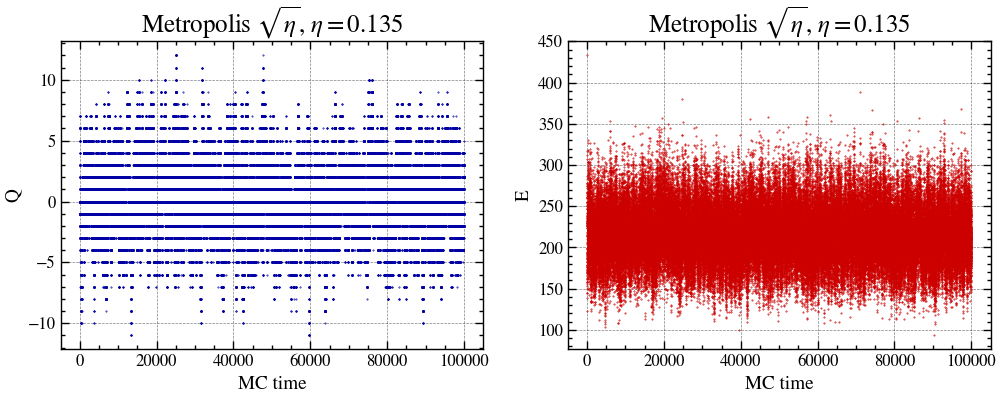

In [512]:
names = os.getcwd() + '/' + dir2 + '/' + 'simulation'
plt.figure(figsize=(12,4)) #b10 
plt.subplot(1, 2, 1)# Address proper subplot in 2x2 array
plt.title(r"Metropolis $\sqrt{\eta}$, $\eta=0.135$")
charges, enes = np.loadtxt(f'{names}_740.txt', unpack=True)
plt.plot(charges,'.',markersize='.8', linewidth='.1',color=getColor('jet', 30, 1), label='')
plt.ylabel(r'Q')
plt.xlabel('MC time')
plt.subplot(1, 2, 2) 
plt.title(r"Metropolis $\sqrt{\eta}$, $\eta=0.135$")
plt.plot(enes,'.',markersize='.8', linewidth='.2',color=getColor('jet', 30, 27), label='')
plt.ylabel(r'E')
plt.xlabel('MC time')

Text(0.5, 0, 'MC time')

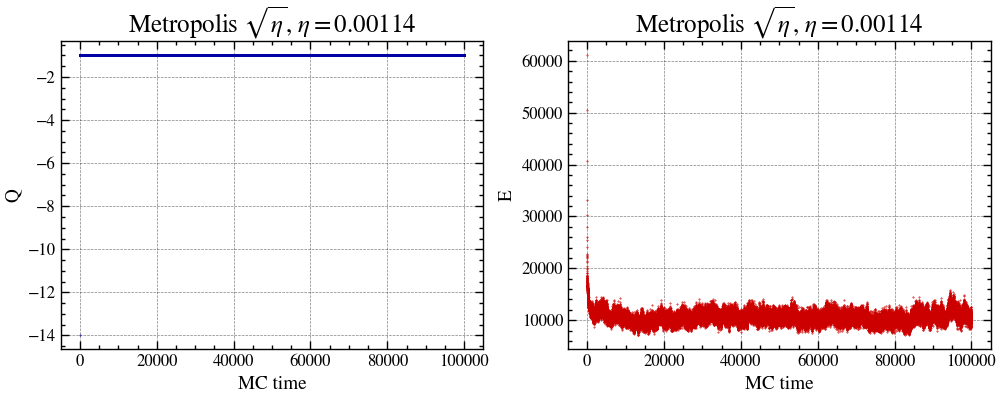

In [516]:
names = os.getcwd() + '/' + dir2 + '/' + 'simulation'
plt.figure(figsize=(12,4)) #b10 
plt.subplot(1, 2, 1)# Address proper subplot in 2x2 array
plt.title(r"Metropolis $\sqrt{\eta}$, $\eta=0.00114$")
charges, enes = np.loadtxt(f'{names}_8703.txt', unpack=True)
plt.plot(charges,'.',markersize='.8', linewidth='.1',color=getColor('jet', 30, 1), label='')
plt.ylabel(r'Q')
plt.xlabel('MC time')
plt.subplot(1, 2, 2) 
plt.title(r"Metropolis $\sqrt{\eta}$, $\eta=0.00114$")
plt.plot(enes,'.',markersize='.8', linewidth='.2',color=getColor('jet', 30, 27), label='')
plt.ylabel(r'E')
plt.xlabel('MC time')

Text(0.5, 0, 'MC time')

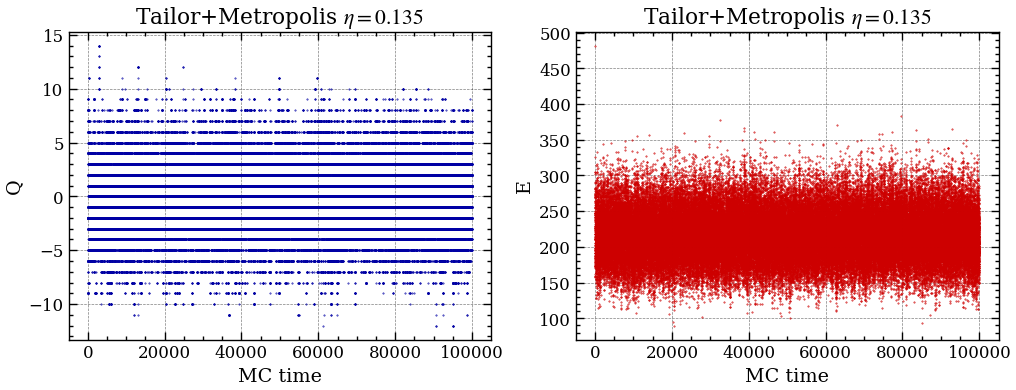

In [549]:
names = os.getcwd() + '/' + dir1 + '/' + 'simulation'
plt.figure(figsize=(12,4)) #b10 
plt.subplot(1, 2, 1)# Address proper subplot in 2x2 array
plt.title(rf"Tailor+Metropolis $\eta=0.135$")
charges, enes = np.loadtxt(f'{names}_740.txt', unpack=True)
plt.plot(charges,'.',markersize='.8', linewidth='.1',color=getColor('jet', 30, 1), label='')
plt.ylabel(r'Q')
plt.xlabel('MC time')
plt.subplot(1, 2, 2) 
plt.title(rf"Tailor+Metropolis $\eta=0.135$")
plt.plot(enes,'.',markersize='.8', linewidth='.2',color=getColor('jet', 30, 27), label='')
plt.ylabel(r'E')
plt.xlabel('MC time')

/var/folders/7b/mxhdlhl16yjddckjcf2qpms00000gn/T/ipykernel_95678/2049406826.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)# Address proper subplot in 2x2 array


Text(0.5, 0, 'MC time')

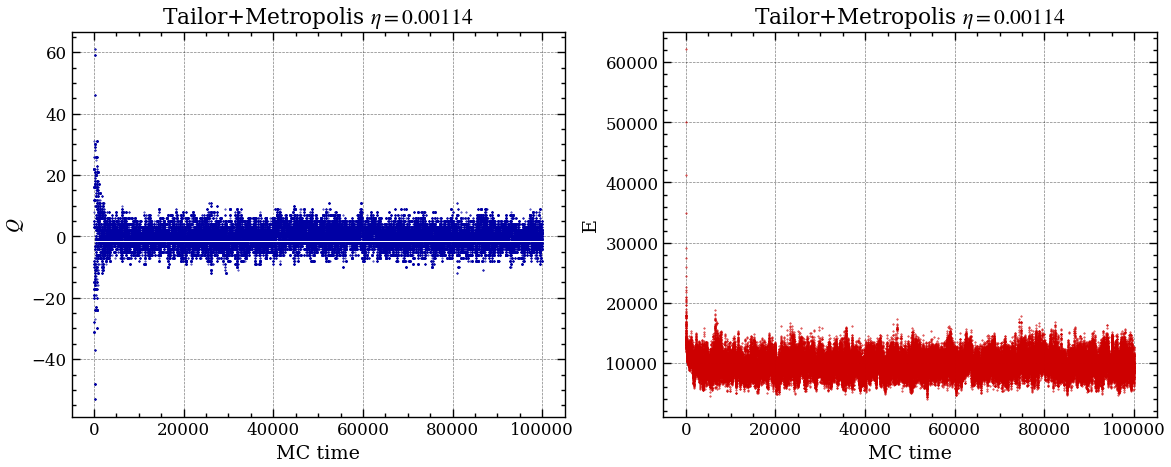

In [548]:
names = os.getcwd() + '/' + dir1 + '/' + 'simulation'
plt.figure(figsize=(14,5)) #b10
plt.title('') 
plt.subplot(1, 2, 1)# Address proper subplot in 2x2 array
plt.title(rf"Tailor+Metropolis $\eta=0.00114$")
charges, enes = np.loadtxt(f'{names}_8703.txt', unpack=True)
plt.plot(charges,'.',markersize='.8', linewidth='.1',color=getColor('jet', 30, 1), label='')
plt.ylabel(r'$Q$')
plt.xlabel('MC time')
#plt.xlim(0, 90000)
#turbojetplt.ylim(-10, 10)
plt.subplot(1, 2, 2)
plt.title(rf"Tailor+Metropolis $\eta=0.00114$")
charges, enes = np.loadtxt(f'{names}_8703.txt', unpack=True)    
plt.plot(enes,'.',markersize='.8', linewidth='.2',color=getColor('jet', 30, 27), label='')
plt.ylabel(r'E')
plt.xlabel('MC time')

# Istogrammi 

In [406]:
eta_hist=np.array([1.0, 0.125, 0.0625, 0.001008267795926598])

In [20]:
np.sort(N)[etas == eta_hist[0]][0]

10

/var/folders/7b/mxhdlhl16yjddckjcf2qpms00000gn/T/ipykernel_95678/2812255232.py:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,4,i+1)


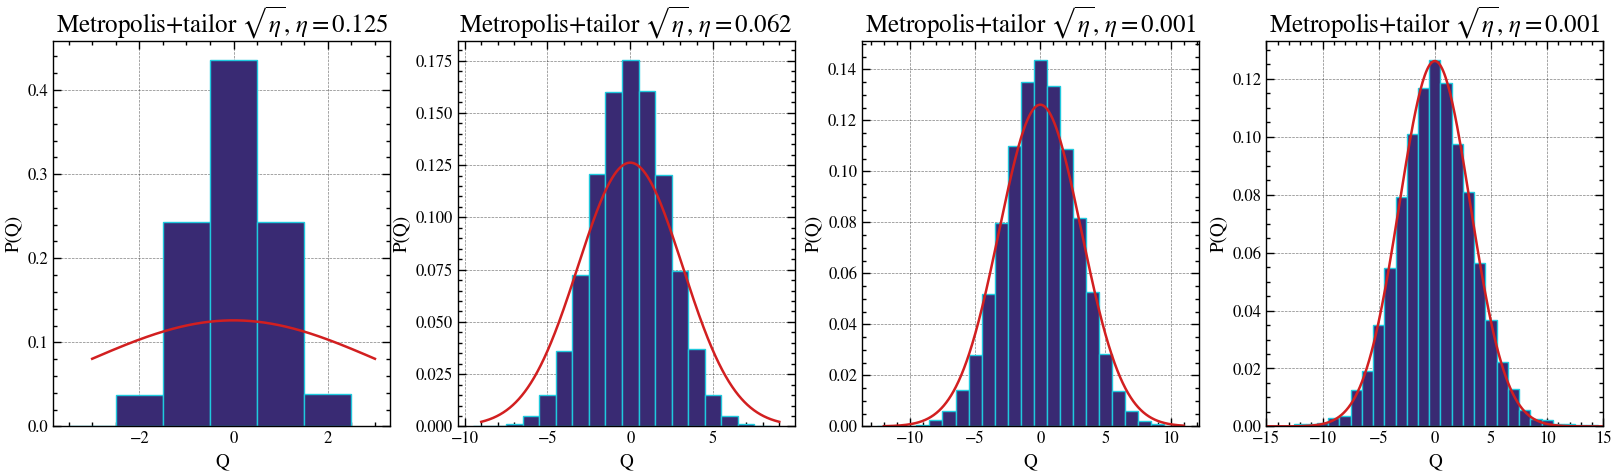

In [490]:
names = os.getcwd() + '/' + dir1 + '/' + 'simulation'
plt.figure(figsize=(20,5))
plt.title('ciao')

for i,e in enumerate(eta_hist):
    key = np.sort(N)[etas == eta_hist[i]][0]
    charges, enes = np.loadtxt(f'{names}_{key}.txt', unpack=True)
    x = np.linspace(min(charges),max(charges),1000)

    b=int(charges.max()-charges.min())
    plt.title(r'Metropolis+tailor $\sqrt{\eta}$,' f' $\eta = {round(e,3)}$')
    
    plt.subplot(1,4,i+1)
    counts, bins = np.histogram(charges,b)
    plt.hist(bins[:-1], bins-0.5, weights=counts, density=True ,color=getColor('turbo', 30,1), ec=getColor('turbo', 30,8),label= 'label')
    plt.plot(x, 1/np.sqrt(2*np.pi*10)*np.exp(-x**2/(2*10)), linewidth=1.8,color=getColor('Reds', 30,21),label= 'label')
    #patch = plt.stairs(counts/counts.sum(), bins-0.5, )
    if i == 3 : 
        plt.xlim(-15,15)
        plt.title(r'Metropolis+tailor $\sqrt{\eta}$,' f' $\eta = {round(e,3)}$')
    plt.xlabel(r'Q')
    plt.ylabel(r'P(Q)')
    

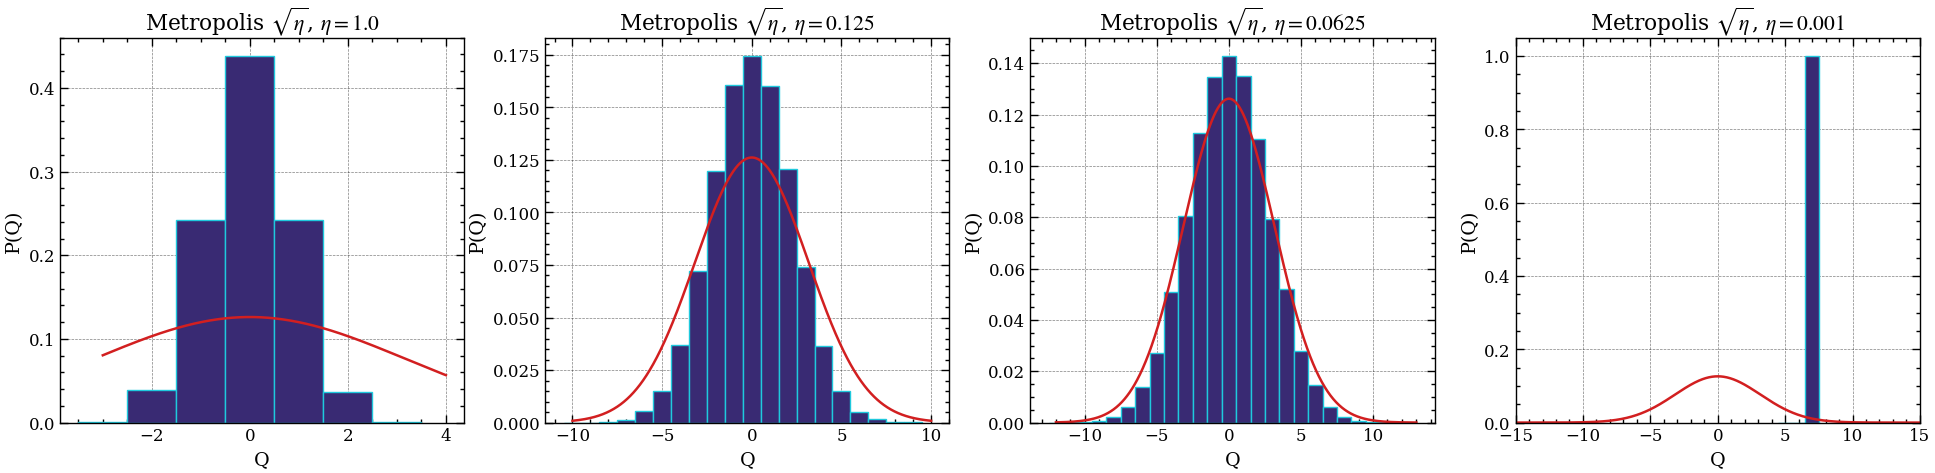

In [545]:
names = os.getcwd() + '/' + dir2 + '/' + 'simulation'
plt.figure(figsize=(24,5))
for i,e in enumerate(eta_hist):
    key = np.sort(N)[etas == eta_hist[i]][0]
    charges, enes = np.loadtxt(f'{names}_{key}.txt', unpack=True)
    x = np.linspace(min(charges),max(charges),1000)
    if i == 3: x = np.linspace(-15,15,1000)   #obbrobrio 
    b=int(charges.max()-charges.min()) 
    plt.subplot(1,4,i+1)
    plt.title(r'Metropolis $\sqrt{\eta}$,' f' $\eta = {e}$')
    counts, bins = np.histogram(charges,b)
    plt.hist(bins[:-1], bins-0.5, weights=counts, density=True ,color=getColor('turbo', 30,1), ec=getColor('turbo', 30,8),label= 'label')
    plt.plot(x, 1/np.sqrt(2*np.pi*10)*np.exp(-x**2/(2*10)), linewidth=1.8,color=getColor('Reds', 30,21),label= 'label')
    #patch = plt.stairs(counts/counts.sum(), bins-0.5, )
    if i == 3 : 
        plt.xlim(-15,15)
        plt.title(r'Metropolis $\sqrt{\eta}$,' f' $\eta = {round(e,3)}$')
    plt.xlabel(r'Q')
    plt.ylabel(r'P(Q)')
    
plt.savefig('isto')

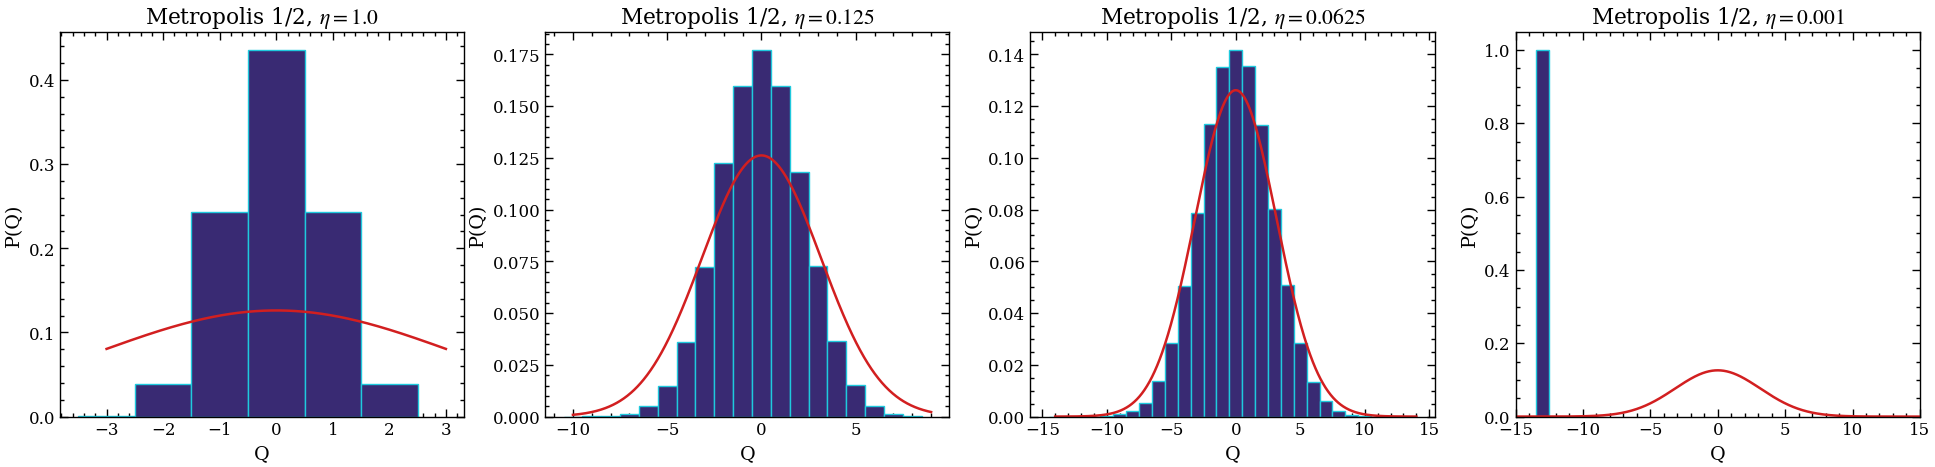

In [555]:
names = os.getcwd() + '/' + dir3 + '/' + 'simulation'
plt.figure(figsize=(24,5))
for i,e in enumerate(eta_hist):
    key = np.sort(N)[etas == eta_hist[i]][0]
    charges, enes = np.loadtxt(f'{names}_{key}.txt', unpack=True)
    x = np.linspace(min(charges),max(charges),1000)
    if i == 3: x = np.linspace(-15,15,1000)   #obbrobrio 
    b=int(charges.max()-charges.min())
    plt.subplot(1,4,i+1)
    plt.grid(False)
    plt.title(fr'Metropolis 1/2, $\eta = {e}$') 
    counts, bins = np.histogram(charges,b)
    plt.hist(bins[:-1], bins-0.5, weights=counts, density=True ,color=getColor('turbo', 30,1), ec=getColor('turbo', 30,8),label= 'label')
    plt.plot(x, 1/np.sqrt(2*np.pi*10)*np.exp(-x**2/(2*10)), linewidth=1.8,color=getColor('Reds', 30,21), label='theoretical')
    #patch = plt.stairs(counts/counts.sum(), bins-0.5, )
    if i == 3 : 
        plt.xlim(-15,15)
        plt.title(fr'Metropolis 1/2, $\eta = {round(eta_hist[3],3)}$')
    plt.xlabel(r'Q')
    plt.ylabel(r'P(Q)')
plt.savefig('isto', dpi=500)

In [412]:
for i,e in enumerate(eta_hist):
    print(e)

1.0
0.125
0.0625
0.001008267795926598


# Varianza (estrapolazione al continuo) 

In [24]:
   #put in input the std(|q|) for each eta and it gives you the correct estimate of the error
def bootstrap_binned(data, bin_size, f, R):
    nb = int(len(data)/bin_size) #num of blocks
    re_samples = np.full(R,0.) #each row will contain the fake resampling std
    blocks = [data[i*bin_size : (i+1)*bin_size] for i in range(nb)]
    #let's pick randomly the block until all the sample is full
    tmp = np.full((nb,bin_size), 0.)
    for j in range(R):
        for k, b in enumerate(np.random.randint(0, nb, size=nb)):
            tmp[k] = blocks[b]
        re_samples[j] = f(tmp.flatten())
    return re_samples

In [25]:
def blocking(data, bin_size):
    nb = int(len(data)/bin_size) #num of blocks
    #lets build the blocks with list comprehension
    blocks = [data[i*bin_size : (i+1)*bin_size] for i in range(nb)]
    averages = np.array([b.mean() for b in blocks]) #average for each block
    return averages.std(ddof=1)/np.sqrt(nb) if nb > 1 else 0

In [26]:
def var_abs(data):
    return abs(data).std(ddof=1)**2

In [27]:
dir1 = 'sim_b10'
dir2 = 'sim_b10_metro'
dir3 = 'sim_b10_metro05'
names = os.getcwd() + '/' + dir1 + '/' + 'simulation'

In [280]:
eta_hist=np.array([0.007757951900698216, 0.005479452054794521, 0.001008267795926598, 0.11235955056179775, 0.045662100456621])

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

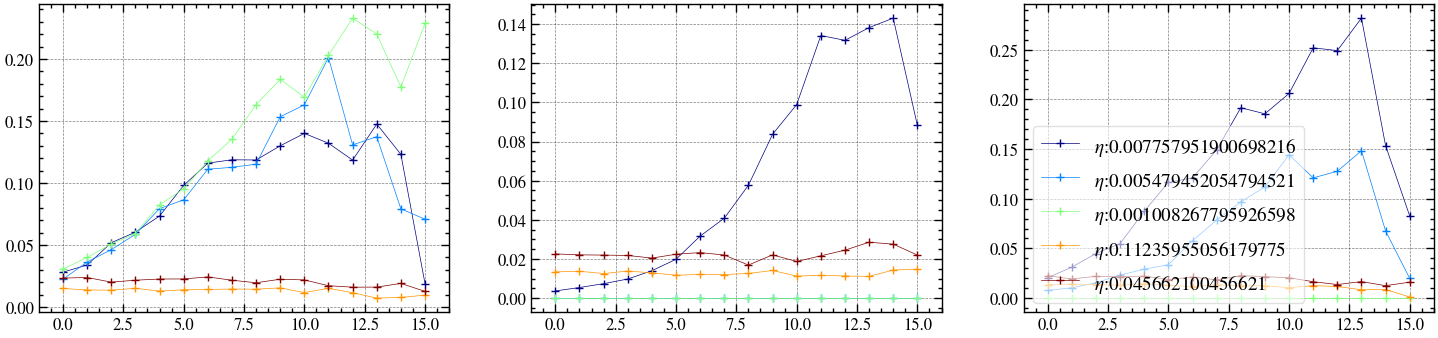

In [393]:
#best block/number of resamples beta=0.43
dirs = [dir1, dir2, dir3]
N_start=34464
plt.figure(figsize=(18,4))
for idx, d in enumerate(dirs):
    names = os.getcwd() + '/' + d + '/' + 'simulation'
    for i,file in enumerate(tqdm(eta_hist)):
        key = np.sort(N)[etas == eta_hist[i]][0]
        sigma_q_try =[]
        charges, ene = np.loadtxt(f'{names}_{key}.txt', unpack=True)
        for k in range(0,16):
            dq_try = bootstrap_binned(np.abs(charges[N_start:]), 2**k, var_abs, 100).std(ddof=1)
            sigma_q_try.append(dq_try)
        plt.subplot(1,3,idx+1)
        plt.plot(list(range(0,16)) , sigma_q_try,'-+',markersize='6', linewidth='.5',color=getColor('jet', 5, i),label=fr'$\eta$:{file}')
        plt.xlim(-1,16) 

plt.legend(loc='lower left',fancybox=True, borderpad=.4, frameon=True, framealpha=.6, handlelength=2, handleheight=1.6, labelspacing=.5)

In [265]:
2**15

32768

In [30]:
dir1 = 'sim_b10'
dir2 = 'sim_b10_metro'
dir3 = 'sim_b10_metro05'
names = os.getcwd() + '/' + dir1 + '/' + 'simulation'

In [259]:
var_q = np.full((len(dirs), len(N)), 0.0)
dvar_q = np.full((len(dirs), len(N)), 0.0)
N_start=34464
for idx, d in enumerate(dirs):    
    names = os.getcwd() + '/' + d + '/' + 'simulation'
    for i, n in enumerate(tqdm(np.sort(N))):
        charges, enes = np.loadtxt(f'{names}_{n}.txt', unpack=True)
        var_q[idx,i] = np.std(charges[N_start:])**2/10
        dvar_q[idx,i] = bootstrap_binned(np.abs(charges[N_start:]), 2**10, var_abs, 200).std(ddof=1)
        

  0%|          | 0/217 [00:00<?, ?it/s]

  0%|          | 0/217 [00:00<?, ?it/s]

  0%|          | 0/217 [00:00<?, ?it/s]

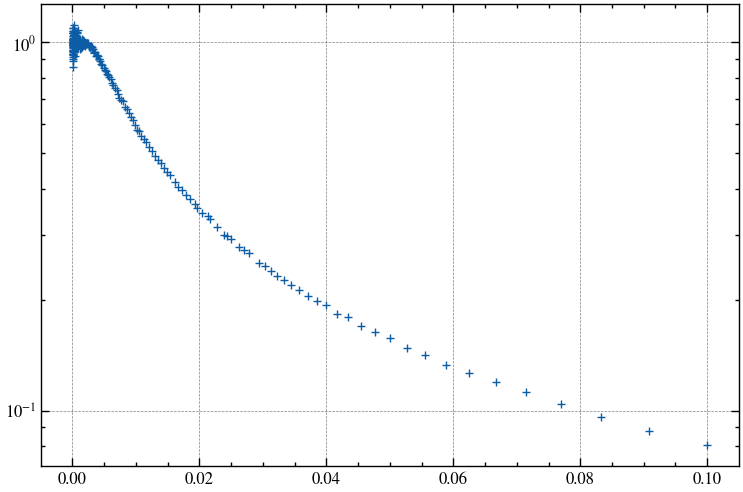

In [32]:
plt.plot( 1/np.sort(N), var_q[0],'+')
plt.yscale('log')

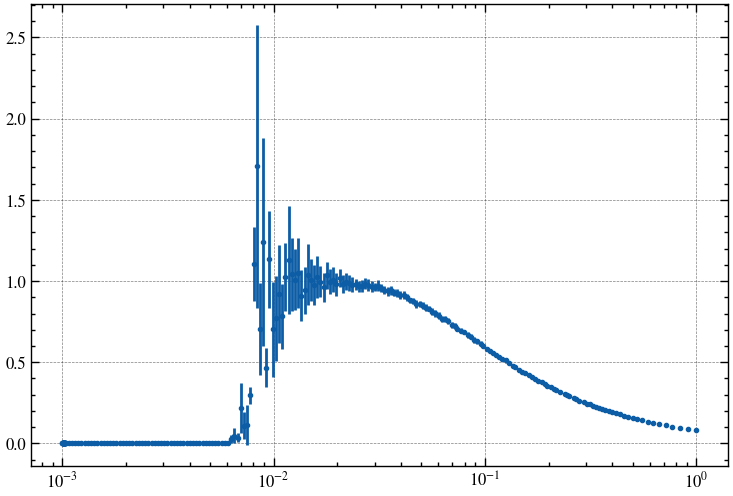

In [67]:
plt.errorbar(etas, var_q[1],dvar_q[1], fmt ='.')
plt.xscale('log')
#plt.xlim((0,0.01))

In [38]:
def constant(x, a):
    return np.full_like(x, a)

def quadratic(x, a, b):
    return a + b * x**2

In [253]:

alg = {
    'metropolis_eta': {'limits': (0.01, 0.094), 'function': quadratic},
    'metropolis_half': {'limits': (0.006, 0.1), 'function': quadratic},
    'metropolis_tailor': {'limits': (0.002, 0.08), 'function': constant}
}


$a$ = 0.9812 ± 0.0060
$b$ = -46.9531 ± 1.3318
chi2, ndof: 42.95558029541127 62


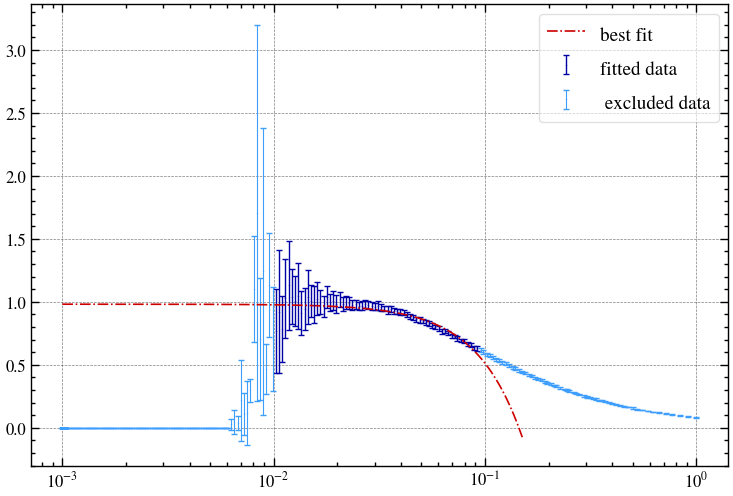

In [391]:
etas = np.array(etas)
lim = alg['metropolis_eta']['limits']
mask = etas>=lim[0] 
mask *= etas<= lim[1]
p0=(1,1)
opt, cov = curve_fit(quadratic, etas[mask], var_q[1][mask], p0,sigma=dvar_q[1][mask], absolute_sigma=True)

w = 1/(dvar_q[1][mask]**2)
chi2 = ((w*(var_q[1][mask]-quadratic(etas[mask],*opt))**2)).sum()
ndof=len(etas[mask])-len(p0)
print(fr'$a$ = {opt[0]:.4f} ± {np.sqrt(cov[0][0]):.4f}')
print(fr'$b$ = {opt[1]:.4f} ± {np.sqrt(cov[1][1]):.4f}')
print ('chi2, ndof:',chi2, ndof)

x=np.linspace(min(etas),0.15,1000)
plt.errorbar(etas[mask], var_q[1][mask] , dvar_q[1][mask],fmt='+',capsize=2 , elinewidth=1,linewidth=1,markersize=.6,label=rf'fitted data',color=getColor('jet', 30, 1))
plt.errorbar(etas[np.logical_not(mask)], var_q[1][np.logical_not(mask)] , dvar_q[1][np.logical_not(mask)],fmt='+',capsize=2 , elinewidth=.8,linewidth=.4,markersize=.6,label=rf' excluded data',color=getColor('turbo', 30, 6))
plt.plot(x , quadratic(x, *opt),'-.',markersize='6', linewidth='1.2',color=getColor('jet', 30, 27), label='best fit')
plt.xscale('log')
plt.legend(loc='upper right',fancybox=True, borderpad=.4, frameon=True, framealpha=.6, handlelength=2, handleheight=1.6, labelspacing=.5)

$a$ = 0.9863 ± 0.0043
$b$ = -45.6044 ± 0.9248
chi2, ndof: 87.78403357694788 79


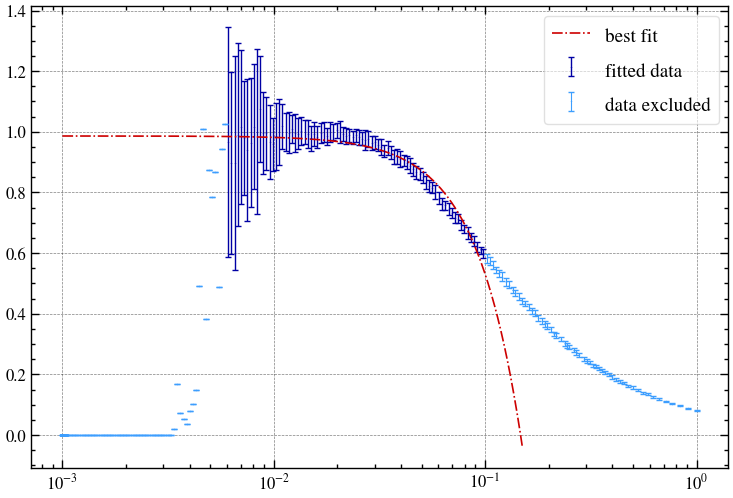

In [389]:
etas = np.array(etas)
lim = alg['metropolis_half']['limits']
mask = etas>=lim[0] 
mask *= etas<= lim[1]
p0=(1,1)
opt, cov = curve_fit(quadratic, etas[mask], var_q[2][mask], p0,sigma=dvar_q[2][mask], absolute_sigma=True)

w = 1/(dvar_q[2][mask]**2)
chi2 = ((w*(var_q[2][mask]-quadratic(etas[mask],*opt))**2)).sum()
ndof=len(etas[mask])-len(p0)
print(fr'$a$ = {opt[0]:.4f} ± {np.sqrt(cov[0][0]):.4f}')
print(fr'$b$ = {opt[1]:.4f} ± {np.sqrt(cov[1][1]):.4f}')
print ('chi2, ndof:',chi2, ndof)

x=np.linspace(min(etas),0.15,1000)
plt.errorbar(etas[mask], var_q[2][mask] , dvar_q[2][mask],fmt='+',capsize=2 , elinewidth=1,linewidth=1,markersize=.6,label=rf'fitted data',color=getColor('jet', 30, 1))
plt.errorbar(etas[np.logical_not(mask)], var_q[2][np.logical_not(mask)] , dvar_q[1][np.logical_not(mask)],fmt='+',capsize=2 , elinewidth=.8,linewidth=.4,markersize=.6,label=rf'data excluded',color=getColor('turbo', 30, 6))
plt.plot(x , quadratic(x, *opt),'-.',markersize='6', linewidth='1.2',color=getColor('jet', 30, 27), label='best fit')
plt.xscale('log')
plt.legend(loc='upper right',fancybox=True, borderpad=.4, frameon=True, framealpha=.6, handlelength=2, handleheight=1.6, labelspacing=.5)

$a$ = 1.0004 ± 0.0062
$b$ = -54.4405 ± 1.8868
chi2, ndof: 21.22571604655469 105


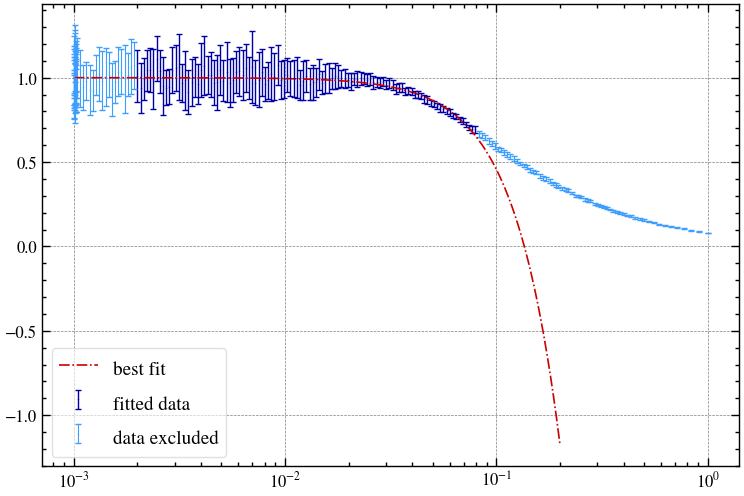

In [387]:
etas = np.array(etas)
lim = alg['metropolis_tailor']['limits']
mask = etas>=lim[0] 
mask *= etas<= lim[1]
p0=(1,1)
opt, cov = curve_fit(quadratic, etas[mask], var_q[0][mask], p0,sigma=dvar_q[0][mask], absolute_sigma=True)

w = 1/(dvar_q[0][mask]**2)
chi2 = ((w*(var_q[0][mask]-quadratic(etas[mask],*opt))**2)).sum()
ndof=len(etas[mask])-len(p0)
print(fr'$a$ = {opt[0]:.4f} ± {np.sqrt(cov[0][0]):.4f}')
print(fr'$b$ = {opt[1]:.4f} ± {np.sqrt(cov[1][1]):.4f}')
print ('chi2, ndof:',chi2, ndof)

x=np.linspace(min(etas),0.2,1000)
plt.errorbar(etas[mask], var_q[0][mask] , dvar_q[0][mask],fmt='+',capsize=2 , elinewidth=1,linewidth=1,markersize=.6,color=getColor('jet', 30, 1), label=rf'fitted data')
plt.errorbar(etas[np.logical_not(mask)], var_q[0][np.logical_not(mask)] , dvar_q[0][np.logical_not(mask)],fmt='+',capsize=2 , elinewidth=.8,linewidth=.4,markersize=.6,label=rf'data excluded',color=getColor('turbo', 30, 6))
plt.plot(x , quadratic(x, *opt),'-.',markersize='6', linewidth='1.2',color=getColor('jet', 30, 27), label='best fit')
plt.xscale('log')
plt.legend(loc='lower left',fancybox=True, borderpad=.4, frameon=True, framealpha=.6, handlelength=2, handleheight=1.6, labelspacing=.5)

In [245]:
dvar_q[0]

array([0.00198846, 0.00194009, 0.00217969, 0.00303325, 0.00291357,
       0.00304443, 0.00314035, 0.00288336, 0.00323257, 0.00377302,
       0.00359128, 0.0042624 , 0.0041644 , 0.00430876, 0.00454077,
       0.00478576, 0.00503556, 0.00439994, 0.0043164 , 0.00514599,
       0.00551735, 0.00519151, 0.00667704, 0.00622571, 0.00571393,
       0.00798577, 0.00722601, 0.00696412, 0.00711904, 0.00730056,
       0.00771231, 0.00757476, 0.0069691 , 0.00741562, 0.00828057,
       0.01002377, 0.00969087, 0.00916345, 0.00905422, 0.01093976,
       0.00969396, 0.00923889, 0.01280304, 0.01071755, 0.01011326,
       0.01179056, 0.01128748, 0.01279536, 0.01279024, 0.01319765,
       0.01302712, 0.01337915, 0.01537575, 0.01268799, 0.01409493,
       0.0135072 , 0.01361837, 0.01487401, 0.01565422, 0.01425502,
       0.01640977, 0.01853981, 0.0178996 , 0.01670659, 0.01824592,
       0.0165349 , 0.01862693, 0.01600302, 0.01678862, 0.01874476,
       0.01943311, 0.01669945, 0.0249918 , 0.01839531, 0.01998

In [247]:
dvar_q[0]

array([0.00195111, 0.00204461, 0.00250615, 0.00276209, 0.00268451,
       0.00271689, 0.00311902, 0.00329219, 0.00327791, 0.00363995,
       0.00348328, 0.00380423, 0.00409764, 0.00429561, 0.00443078,
       0.00472597, 0.00484868, 0.00514742, 0.0052962 , 0.00542693,
       0.00602032, 0.00562694, 0.00577953, 0.0058015 , 0.00608443,
       0.00661387, 0.00660116, 0.00689042, 0.00724058, 0.006925  ,
       0.00823134, 0.00846941, 0.00779074, 0.00802221, 0.00862935,
       0.00905469, 0.00909171, 0.01010035, 0.00914165, 0.01033743,
       0.01039441, 0.01048794, 0.01045162, 0.01094549, 0.01029826,
       0.01105639, 0.01242868, 0.01252955, 0.01303165, 0.01377883,
       0.01359848, 0.01282677, 0.01447054, 0.01455212, 0.01446669,
       0.01533693, 0.01487282, 0.01656204, 0.01387746, 0.01630349,
       0.01701136, 0.01565825, 0.01496399, 0.01541327, 0.01937094,
       0.01919671, 0.01836445, 0.01885734, 0.01938631, 0.01945692,
       0.01958703, 0.02013772, 0.02063353, 0.02077865, 0.02036

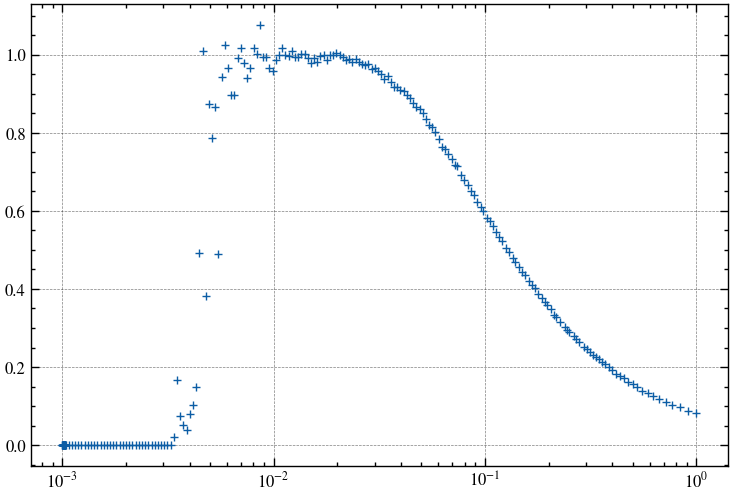

In [148]:
plt.plot(etas,var_q[2],'+')
plt.xscale('log')

# Accettanza 

In [ ]:
dir1 = 'sim_b10'
dir2 = 'sim_b10_metro'
dir3 = 'sim_b10_metro05'
names = os.getcwd() + '/' + dir1 + '/' + 'simulation'
acc_dir = os.getcwd() + '/' + dir1 + '/acc/' + 'acc' 

In [305]:
acceptance = np.full((2,len(etas)),0.) #etas=10/np.sort(N)
for idx, d in enumerate([dir2,dir3]):
    acc_dir = os.getcwd() + '/' + d + '/acc/' + 'acc'
    acc=[]    
    for i,n in enumerate(tqdm(np.sort(N))):
        acc_file = np.loadtxt(f'{acc_dir}_{n}.txt', unpack=True)
        acc.append(acc_file)
    acceptance[idx] = acc

  0%|          | 0/217 [00:00<?, ?it/s]

  0%|          | 0/217 [00:00<?, ?it/s]

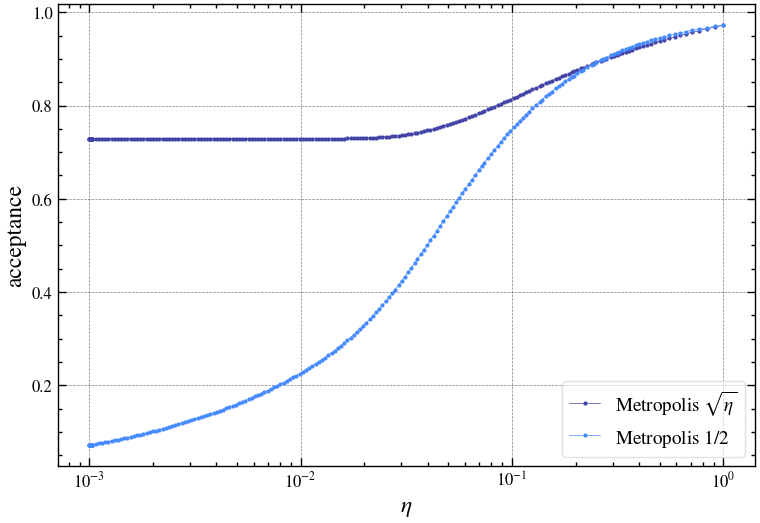

In [378]:
plt.plot(etas, acceptance[0],'.-',markersize='4', linewidth='.5',color=getColor('turbo', 30, 2), label=r'Metropolis $\sqrt{\eta}$')
plt.plot(etas, acceptance[1],'.-',markersize='4', linewidth='.5',color=getColor('turbo', 30, 5), label=r'Metropolis $1/2$')
plt.xscale('log')
plt.xlabel(r'$\eta$')
plt.ylabel('acceptance')
#plt.yscale('log')
plt.legend(loc='lower right',fancybox=True, borderpad=.4, frameon=True, framealpha=.6, handlelength=1.6, handleheight=1, labelspacing=.5)

In [317]:
plt.legend?

Signature: plt.legend(*args, **kwargs)
Docstring:
Place a legend on the Axes.

Call signatures::

    legend()
    legend(handles, labels)
    legend(handles=handles)
    legend(labels)

The call signatures correspond to the following different ways to use
this method:

**1. Automatic detection of elements to be shown in the legend**

The elements to be added to the legend are automatically determined,
when you do not pass in any extra arguments.

In this case, the labels are taken from the artist. You can specify
them either at artist creation or by calling the
:meth:`~.Artist.set_label` method on the artist::

    ax.plot([1, 2, 3], label='Inline label')
    ax.legend()

or::

    line, = ax.plot([1, 2, 3])
    line.set_label('Label via method')
    ax.legend()

.. note::
    Specific artists can be excluded from the automatic legend element
    selection by using a label starting with an underscore, "_".
    A string starting with an underscore is the default label for all
    artis

In [290]:
a = np.full((2,3),0)
a

array([[0, 0, 0],
       [0, 0, 0]])